In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, Huber
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [23]:
df = pd.read_csv("outputs/preprocessed_data/nasa_data_cleaned.csv")
df.shape

(116892, 37)

In [24]:
# Convert to datetime
df['DATE'] = pd.to_datetime(df[['YEAR', 'MO', 'DY']].rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day'}))

# Sort by DATE
df = df.sort_values(by=["LAT", "LON", "DATE"])


In [25]:
df['DATE_DIFF'] = df['DATE'].diff().dt.days

disconnects = df[df['DATE_DIFF'] > 1][['DATE', 'DATE_DIFF']]

# Get value counts of the different gap lengths
disconnect_counts = disconnects['DATE_DIFF'].value_counts().reset_index()
disconnect_counts.columns = ['Gap Length (Days)', 'Frequency']
disconnect_counts = disconnect_counts.sort_values(by='Gap Length (Days)')
disconnect_counts

,Gap Length (Days),Frequency
2,2.0,320
1,3.0,1280
0,4.0,2205


In [26]:
# Create a complete date range for each unique (LAT, LON)
full_dates = pd.date_range(start=df["DATE"].min(), end=df["DATE"].max())

# Create a DataFrame with all combinations of (LAT, LON) and full dates
unique_locations = df[["LAT", "LON"]].drop_duplicates()
expanded_dates = unique_locations.assign(key=1).merge(pd.DataFrame({"DATE": full_dates, "key": 1}), on="key").drop("key", axis=1)

# Merge the original dataset with the full date range to introduce missing dates per location
df_filled = expanded_dates.merge(df, on=["LAT", "LON", "DATE"], how="left")

# Interpolate missing values within each (LAT, LON) group
df_filled = df_filled.groupby(["LAT", "LON"]).apply(lambda group: group.interpolate(method="linear")).reset_index(drop=True)

# Forward-fill and backward-fill remaining missing values (if any)
df_filled.fillna(method="ffill", inplace=True)
df_filled.fillna(method="bfill", inplace=True)

df = df_filled

C:\Users\obada\AppData\Local\Temp\ipykernel_37328\1546678154.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df_filled.groupby(["LAT", "LON"]).apply(lambda group: group.interpolate(method="linear")).reset_index(drop=True)
C:\Users\obada\AppData\Local\Temp\ipykernel_37328\1546678154.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled.fillna(method="ffill", inplace=True)
C:\Users\obada\AppData\Local\Temp\ipykernel_37328\1546678154.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_fill

In [27]:
panel_area = 1.8
efficiency = 0.20
sun_hours = 5

df["E_produced"] = df["ALLSKY_SFC_SW_DWN"] * panel_area * efficiency * sun_hours 

In [28]:
selected_features = ["LAT", "LON", "ALLSKY_SFC_SW_DWN", "WS2M", "T2M", "RH2M", "PRECTOTCORR", 'T2M_MAX','T2M_MIN', "ALLSKY_KT", 'ALLSKY_SFC_PAR_TOT', ]  
target = ["E_produced"]

scaler = MinMaxScaler()
df[selected_features + target] = scaler.fit_transform(df[selected_features + target])

In [29]:
def create_sequences(data, target, seq_length=15):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(df[selected_features].values, df[target].values, seq_length=15)

In [30]:
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[-test_size:], y[-test_size:]

In [31]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
    Dropout(0.3),
    BatchNormalization(),
    
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    BatchNormalization(),

    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(1)
])

c:\Users\obada\data-analysis\renewable_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),  # More patience
    ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=6, min_lr=1e-7, verbose=1)  # Higher min_lr
]

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Keep learning rate reasonable
    loss="mse",
    metrics=["mae"],
)


In [34]:
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/40
9364/9364 ━━━━━━━━━━━━━━━━━━━━ 118s 12ms/step - loss: 0.2333 - mae: 0.3458 - val_loss: 0.0138 - val_mae: 0.1027 - learning_rate: 1.0000e-04
Epoch 2/40
9364/9364 ━━━━━━━━━━━━━━━━━━━━ 108s 12ms/step - loss: 0.0164 - mae: 0.0974 - val_loss: 0.0046 - val_mae: 0.0456 - learning_rate: 1.0000e-04
Epoch 3/40
9364/9364 ━━━━━━━━━━━━━━━━━━━━ 112s 12ms/step - loss: 0.0081 - mae: 0.0672 - val_loss: 0.0039 - val_mae: 0.0318 - learning_rate: 1.0000e-04
Epoch 4/40
9364/9364 ━━━━━━━━━━━━━━━━━━━━ 115s 12ms/step - loss: 0.0061 - mae: 0.0574 - val_loss: 0.0042 - val_mae: 0.0454 - learning_rate: 1.0000e-04
Epoch 5/40
9364/9364 ━━━━━━━━━━━━━━━━━━━━ 108s 11ms/step - loss: 0.0054 - mae: 0.0536 - val_loss: 0.0034 - val_mae: 0.0320 - learning_rate: 1.0000e-04
Epoch 6/40
9364/9364 ━━━━━━━━━━━━━━━━━━━━ 109s 12ms/step - loss: 0.0050 - mae: 0.0512 - val_loss: 0.0037 - val_mae: 0.0379 - learning_rate: 1.0000e-04
Epoch 7/40
9364/9364 ━━━━━━━━━━━━━━━━━━━━ 107s 11ms/step - loss: 0.0048 - mae: 0.0502 - val_lo

In [35]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

1004/1004 - 5s - 5ms/step - loss: 6.0897e-04 - mae: 0.0198
Test Loss: 0.000608972564805299, Test MAE: 0.019807705655694008


In [36]:
target_scaler = MinMaxScaler()
target_scaler.fit(df[['E_produced']])  # Fit only on the target column

MinMaxScaler()

In [37]:
y_pred = model.predict(X_test)
y_pred_rescaled = target_scaler.inverse_transform(y_pred)  
y_test_rescaled = target_scaler.inverse_transform(y_test)


1004/1004 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step


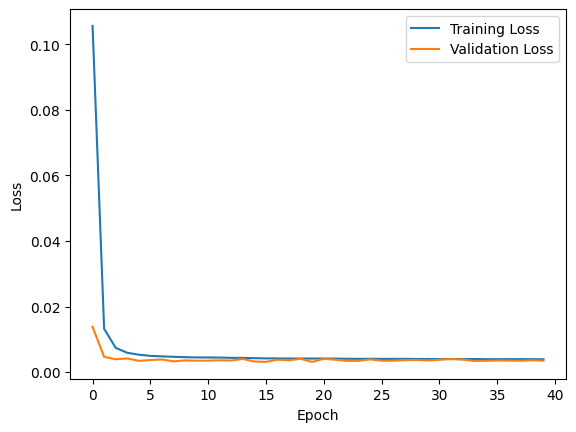

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


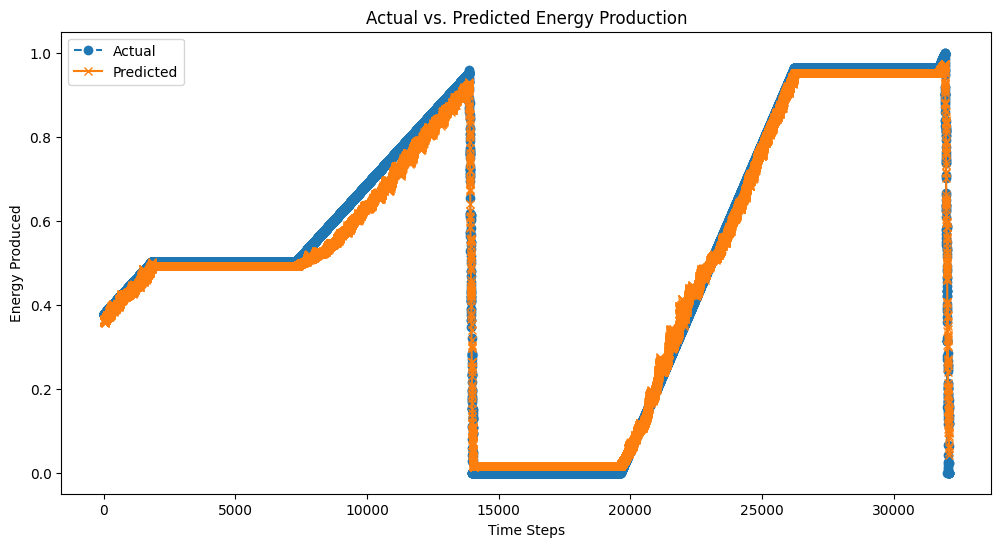

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual", marker='o', linestyle="dashed")
plt.plot(y_pred_rescaled, label="Predicted", marker='x')
plt.xlabel("Time Steps")
plt.ylabel("Energy Produced")
plt.legend()
plt.title("Actual vs. Predicted Energy Production")
plt.show()


In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

MAE: 0.01980757890532171
MSE: 0.0006089694647191811
RMSE: 0.024677306674740277
R² Score: 0.9945500388094574


In [41]:
df.shape

(214035, 40)

In [42]:
model.save("outputs/models/model.h5")

In [43]:
!jupyter nbconvert --to script "renewable_time_serise_tracker.ipynb" --output-dir="outputs/scripts"
!jupyter nbconvert --to html "renewable_time_serise_tracker.ipynb" --output-dir="outputs/html"

C:\Users\obada\AppData\Local\Programs\Python\Python313\Scripts\jupyter-nbconvert.EXE\__main__.py:4: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
[NbConvertApp] Converting notebook renewable_time_serise_tracker.ipynb to script
[NbConvertApp] Writing 5973 bytes to outputs\scripts\renewable_time_serise_tracker.py
C:\Users\obada\AppData\Local\Programs\Python\Python313\Scripts\jupyter-nbconvert.EXE\__main__.py:4: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid troub